<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/korea_news_topics/korea_news_topics_classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Data/KorNews_topic"

/content/drive/MyDrive/Data/KorNews_topic


In [3]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random, os, gc
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from transformers import (AutoTokenizer,
                          AdamW,
                          AutoModelForSequenceClassification)

plt.style.use('ggplot')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)
SEED = 42

In [6]:
data = pd.read_csv('./train_data.csv')
topic = pd.read_csv('./topic_dict.csv')
display(topic)
display(data.head())

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
id2label = topic.to_dict()['topic']
label2id = {label: id for id, label in id2label.items()}
print(id2label)
print(label2id)

{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
{'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}


In [8]:
data.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

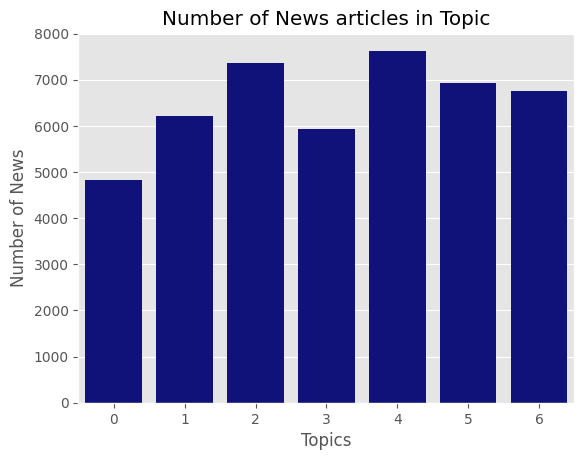

In [9]:
sns.countplot(data, x='topic_idx', color='darkblue')
plt.title('Number of News articles in Topic')
plt.xlabel('Topics')
plt.ylabel('Number of News')
plt.show()

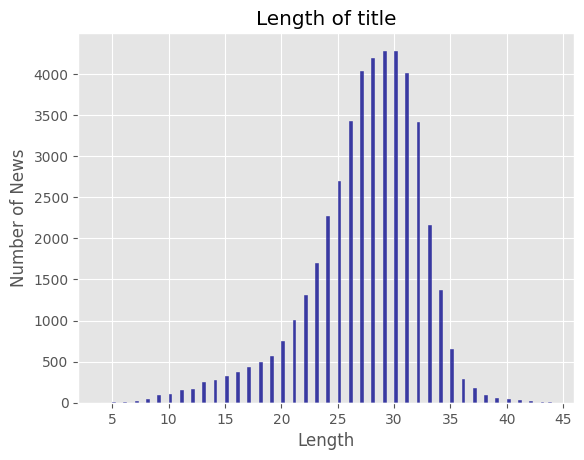

In [10]:
sns.histplot(data['title'].str.len(), color='darkblue')
plt.title('Length of title')
plt.xlabel('Length')
plt.ylabel('Number of News')
plt.show()

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(data.index.values,
                                                    data.topic_idx.values,
                                                    test_size=0.2,
                                                    stratify=data.topic_idx.values,
                                                    random_state = SEED)

In [12]:
data['data_type'] =['not_set'] * data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_valid, 'data_type'] = 'valid'
data.head()

,index,title,topic_idx,data_type
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,train
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,train
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,train
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,train
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,valid


In [13]:
pd.DataFrame(data.groupby(['topic_idx', 'data_type'])['index'].count())

index
topic_idx data_type       
0         train       3859
          valid        965
1         train       4978
          valid       1244
2         train       5890
          valid       1472
3         train       4746
          valid       1187
4         train       6103
          valid       1526
5         train       5546
          valid       1387
6         train       5401
          valid       1350

In [14]:
# split train valid dataset
train_set = data[data.data_type == 'train']
valid_set = data[data.data_type == 'valid']

In [15]:
# # split train valid dataset
# train_set = data[data.data_type == 'train'].sample(n=2000)
# valid_set = data[data.data_type == 'valid'].sample(n=500)

In [16]:
MODEL_NAME = 'jason9693/SoongsilBERT-base-beep'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [17]:
max_len = 64

train_text = train_set.title.values.tolist()
valid_text = valid_set.title.values.tolist()

encoded_data_train = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_len,
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    valid_text,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_len,
    return_tensors='pt',
    truncation=True
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_set.topic_idx.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(valid_set.topic_idx.values)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
valid_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [19]:
BATCH_SIZE = 16
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                           num_labels=len(id2label),
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jason9693/SoongsilBERT-base-beep and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
class Trainer():
  torch.cuda.empty_cache()
  gc.collect()
  def __init__(self, trainloader, validloader, model, optimizer, device):
    self.trainloader = trainloader
    self.validloader = validloader
    self.model = model
    self.optimizer = optimizer
    self.device = device

  def train(self, epochs=1):
    self.model.train()
    # best_acc, best_loss = None, None
    for epoch in range(1, epochs+1):
      print('===========Epoch:{:1d}/{:1d}==================='.format(epoch, epochs))
      running_loss = 0.0
      for input_ids, attention_masks, labels  in tqdm(self.trainloader):
        input_ids = input_ids.to(self.device)
        attention_mask = attention_masks.to(self.device)
        labels = labels.to(self.device)
        inputs = {'input_ids':input_ids,
                  'attention_mask': attention_mask}

        self.optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)

        loss = outputs[0]
        running_loss += loss.item()
        loss.backward()
        self.optimizer.step()

      train_loss = running_loss / len(self.trainloader)
      valid_loss, accuracy = self.validate()
      tqdm.write('Epoch:{:1d}, Train loss: {:.3f}, Validation loss: {:.3f}, Accuracy: {:.3f}'.format(epoch, train_loss, valid_loss, accuracy))
      # if best_acc is None and best_loss is None:
      #   best_loss = valid_loss
      #   best_acc = accuracy


  def validate(self):
    self.model.eval()
    predictions, labels_concat =[], []
    with torch.no_grad():
      running_loss = 0.0
      correct = 0
      for input_ids, attention_mask, labels in tqdm(self.validloader):
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)
        labels = labels.to(self.device)
        inputs = {'input_ids':input_ids,
                  'attention_mask': attention_mask
                  }

        outputs = model(**inputs, labels=labels)

        loss = outputs.loss
        running_loss += loss.item()
        logits = outputs.logits

        predicted = logits.detach().cpu().numpy().argmax(1)
        labels = labels.detach().cpu().numpy()
        predictions.append(predicted)
        labels_concat.append(labels)

      valid_loss = running_loss/len(self.validloader)
      predictions = np.concatenate(predictions, axis=0)
      labels_concat = np.concatenate(labels_concat, axis=0)
      accuracy = sum(predictions==labels_concat)/len(labels_concat)
      return valid_loss, accuracy

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
LEARNING_RATES = 2e-5
optimizer = AdamW(model.parameters(), lr =LEARNING_RATES, no_deprecation_warning=True)
model = model.to(device)

In [23]:
trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  model = model,
                  optimizer = optimizer,
                  device = device)
trainer.train(epochs=3)

===========Epoch:1/3===================


  0%|          | 0/2283 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

Epoch:1, Train loss: 0.511, Validation loss: 0.371, Accuracy: 0.877
===========Epoch:2/3===================


  0%|          | 0/2283 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

Epoch:2, Train loss: 0.309, Validation loss: 0.418, Accuracy: 0.862
===========Epoch:3/3===================


  0%|          | 0/2283 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

Epoch:3, Train loss: 0.199, Validation loss: 0.409, Accuracy: 0.868
